In [17]:
from collections import defaultdict
import numpy as np
from itertools import combinations
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from matplotlib import pyplot as plt
import networkx as nx
import networkx.generators.community as community
from networkx.generators.random_graphs import connected_watts_strogatz_graph as small_world
from networkx.generators.random_graphs import powerlaw_cluster_graph as cluster
import ndlib
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.utils import multi_runs
from bokeh.palettes import Category20_9 as cols
import future.utils
import warnings
import time
from random import randint
from random import sample
warnings.simplefilter('ignore')
%matplotlib inline

no display found. Using non-interactive Agg backend


### Max-Cut on D-Wave machines functions

In [8]:
def maxcut_qubo(G):
    """
    Generate a QUBO instance Q representing Max-Cut on G
    """
    Q = defaultdict(int)
    for u, v in G.edges:
        Q[(u,u)]+= -1
        Q[(v,v)]+= -1
        Q[(u,v)]+= 2
    return Q

def solve(Q, chainstrength=8, numruns=100):
    """
    Solve a QUBO Q on a D-Wave machine 
    """
    sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
    response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
    energies = iter(response.data())
    return response.first

def binary_split(G, limit = 4, pos=None, infected_nodes=[], graph=False, print_progress=False, weighted=False):
    """ 
    Recursively call Max-Cut on graph G, splitting into groups until the size of each group reaches limit.
    infected_nodes, graph, pos, and print_progress allow for visualizing process
    weighted allows for weighted Max-Cut
    """
    
    if pos == None:
        pos = nx.spring_layout(G)

    if len(G.nodes) <= limit or len(G.edges) == 0: #recursion base case and if no edges D-Wave will error
        return [G]
    else: # split into two groups       
        if weighted == False:
            Q = maxcut_qubo(G)
        else:
            Q = weighted_maxcut_qubo(G)
        sol = solve(Q)
        
    labels = sol.sample
    for node in G.nodes: # D-Wave doesn't assign labels to isolated vertices so assign to 0
        if node not in labels:
            labels[node] = 0
    
    # assign all nodes labeled 0 to 'left' and all else to 'right.' Color left red, right blue, and infected green
    colors = ['g' if i in infected_nodes else ('r' if labels[i] == 0 else 'b') for i in G.nodes]
    left = [i for i in G.nodes if labels[i] == 0] 
    right = [i for i in G.nodes if labels[i] == 1]
    
    # graphing and reporting progress
    if graph:
        fig = plt.figure(constrained_layout=False)
        gs = fig.add_gridspec(nrows=2, ncols=3)
        gs.update(wspace=0, hspace=0)
        ax1 = fig.add_subplot(gs[:,:2])   
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax2 = fig.add_subplot(gs[0,2])  
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax3 = fig.add_subplot(gs[1,2]) 
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])    
    left_G = G.subgraph(left)
    right_G = G.subgraph(right)
    left_colors = ['g' if i in infected_nodes else 'r'  for i in left_G.nodes]
    right_colors = ['g' if i in infected_nodes else 'b' for i in right_G.nodes]
    if print_progress == True:
        print("Dividing {} people into {} & {}".format(len(G.nodes), len(left_G.nodes), len(right_G.nodes)))    
    if graph:
        nx.draw_networkx(G, node_size=300, alpha=.8, ax=ax1, pos=pos, node_color=colors)
        nx.draw_networkx(left_G, node_size=300, alpha=.8, ax=ax2, pos=pos, node_color=left_colors)
        nx.draw_networkx(right_G, node_size=300, alpha=.8, ax=ax3, pos=pos, node_color=right_colors)
    
    #recursively call Max-Cut on left and right groups
    group = []
    group.extend(binary_split(left_G, pos=pos, infected_nodes=infected_nodes, limit=limit, graph=graph))    
    group.extend(binary_split(right_G, pos=pos, infected_nodes=infected_nodes, limit=limit, graph=graph))     
    
    return group

In [15]:
def sim_virus(G, r_infect=0.001, r_recover=0.01, infected_nodes = [], iteration=500):
    """
    Simulates virus spread on entire graph G with initial infected nodes and disease properties
    iteration: number of steps of virus spread
    returns: model, trends: dictionary indexed by number of susceptible (0), infected (1) and removed (2) nodes
    iterations: dictionary indexed by iteration, containing the state of every node at that iteration
    https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html
    """
    model = ep.SIRModel(G)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', r_infect) # infection rate
    cfg.add_model_parameter('gamma', r_recover) # recovery rate
    cfg.add_model_initial_configuration("Infected", infected_nodes)
    model.set_initial_status(cfg)
    iterations = model.iteration_bunch(iteration, node_status=False)
    trends = model.build_trends(iterations)     
    return model, trends, iterations 

In [39]:
def plot(viz, ax, title):
    """
    Plot the spread of disease over time 
    viz: Data returned by virus simulations
    ax: axis to plot on
    group_status: title of plot
    """
    pres = viz.iteration_series(90)
    mx = 0
    i = 0
    for k, l in future.utils.iteritems(pres):
        mx = len(l[0])
        if viz.normalized:
            ax.plot(range(0, mx), l[1]/viz.nnodes, lw=2, label=viz.srev[k], alpha=0.5, color=cols[i])
            ax.fill_between(range(0,  mx), l[0]/viz.nnodes, l[2]/viz.nnodes, alpha=0.2, # had to change alpha to a float
                             color=cols[i])
        else:
            ax.plot(range(0, mx), l[1], lw=2, label=viz.srev[k], alpha=0.5, color=cols[i])
            ax.fill_between(range(0, mx), l[0], l[2], alpha=0.2, # had to change alpha to a float
                             color=cols[i])
        i += 1
    ax.grid(axis="y")
    ax.set_title(title)
    ax.set_xlabel("Iterations", fontsize=24)
    ax.set_ylabel(viz.ylabel, fontsize=24)
    ax.legend(loc="best", fontsize=18)
    ax.set_xlim((0, mx))

def plot_virus_spread(G, infected, r_infect=0.001, r_recover=0.01, iterations = 1000, weighted = False):    
    """
    Plot side by side comparisons of disease spread in the quarantined and un-quarantined cases for groups of size
    given by group_sizes
    """
    original_model, original_trends, _ = sim_virus(G, infected_nodes = infected, iteration = iterations, 
                                                   r_infect = r_infect, r_recover=r_recover)
    original_viz = DiffusionTrend(original_model, original_trends)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    viz = DiffusionTrend(original_model, original_trends)
    plot(original_viz, ax[0], 'No Quarantine')

In [52]:
def random_avg_distance(G, samples):
    distance_sum = 0
    for i in range(samples):
        pair = sample(list(G.nodes()), 2)
        #print(pair)
        distance = len(nx.shortest_path(G, pair[0], pair[1]))
        #print(distance)
        distance_sum += distance
    return distance_sum/samples

def random_avg_clustering_coeff(G, samples):
    sampled_nodes = sample(list(G.nodes()), samples)
    clustering_dict = nx.clustering(G, sampled_nodes)
    return np.mean(np.array(list(clustering_dict.values())))

def avg_degree(G):
    return 2 * G.number_of_edges() / G.number_of_nodes()

In [83]:
toy_small_world = small_world(2000, 100, .15)
initial_infected_nodes = np.random.choice(range(38), int(10), replace=False)
print('clustering coef: ', random_avg_clustering_coeff(toy_small_world, 20))
print('density: ', nx.density(toy_small_world))
print('degree: ', avg_degree(toy_small_world))

clustering coef:  0.4747658451821898
density:  0.05002501250625312
degree:  100.0


We must specify an infection and recovery rate for covid-19, we try do that here: 

For COVID 19 Some stats are: Basic reproductive number around 2.5: https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article

This means the number of susceptible people expected to get infected by 1 infected covid patient is 2.5

Patients are infected for 2-14 days https://www.worldometers.info/coronavirus/coronavirus-incubation-period/

Lets say infections last 10 days. Then over 10 days, 2.5 people in contact with them get infected, so .25 nodes should be infected per day. If the average degree is d, then r_infect should be .25/d.

Then if it takes 10 days to be removed - either by recovery or death, we expect r_recover to be a probability that yields a geometric distribution with a mean of 10. Expected value is 1/p for geom distribution so p = 1/10 = .1, we previously used .01. So we increase both rates, lets see what happens.


So this seems to have the desired statistics for the networks we are modelling

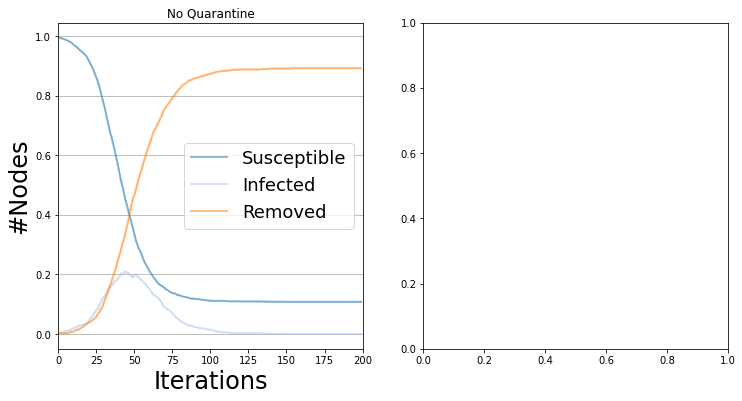

In [85]:
plot_virus_spread(toy_small_world, initial_infected_nodes, r_infect = .25/avg_degree(toy_small_world), r_recover = .1, iterations = 200)

This looks like exponential growth. This is weak evidence to support our r_infect and r_recover rates